## Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [1]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


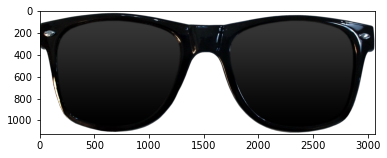

In [2]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 


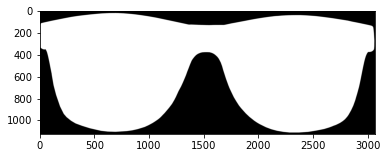

In [3]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [4]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109], dtype=int64), array([ 687,  688,  689, ..., 2376, 2377, 2378], dtype=int64))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

In [5]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [6]:
# helper function to display keypoints
def show_keypoints(image, key_pts, marker_size=20, cmap=None):
    """Show image with keypoints"""
    plt.imshow(image, cmap=cmap)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=marker_size, marker='.', c='m')


Image name:  Priyanka_Chopra_10.jpg


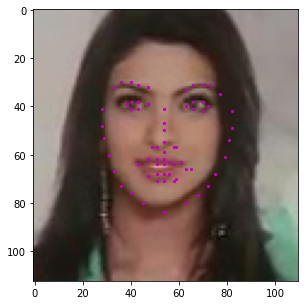

In [7]:
# a selected image
def select_image(index):
    image_name = key_pts_frame.iloc[index, 0]
    image = mpimg.imread(os.path.join('data/training/', image_name))
    key_pts = key_pts_frame.iloc[index, 1:].values
    key_pts = key_pts.astype('float').reshape(-1, 2)
    return image_name, image, key_pts

image_name, image, key_pts = select_image(150)
print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

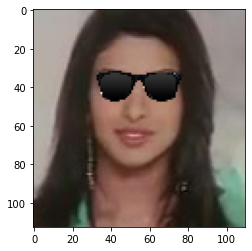

In [8]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(image)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[34,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
plt.imshow(image_copy)

#### Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.

Rotation angle (in degrees): -8.785298717884604


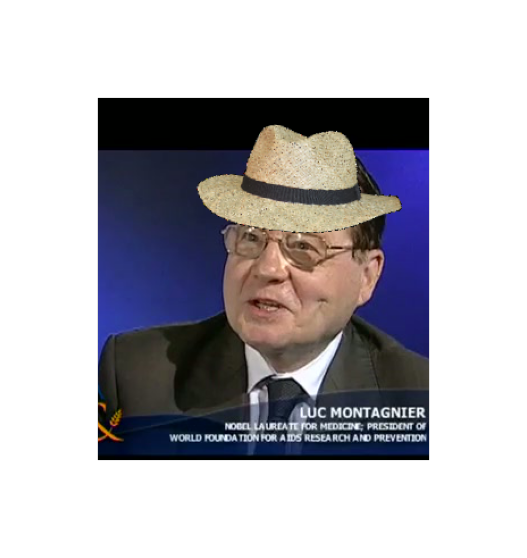

In [28]:
import math  

# configuration for each filtering object
# height/width keypoint tuple to get difference between the points, and scale_factor to scale this difference
# anchor x_keypoints and y_keypoints are similar, but both values in tuple can be same as well
# if both values are not same, then anchor is the first point + average of the two values in tuple
# anchor offset keypoints and offset scale_factor are used for calculating directional offsets from anchor points
# tilt factor is used to determine the horizontal offset needed for tilted objects
config_dict = {
    'sunglasses':
        {'height':
            {'keypoints': (27, 34),
            'scale_factor': 1.0},
        'width':
            {'keypoints': (17, 26),
            'scale_factor': 1.2},
        'anchor':
            {'x_keypoints': (27, 27),
             'y_keypoints': (27, 27),         
             'x_offset': 
                 {'keypoints': (27, 27),
                 'scale_factor': 1.0},
             'y_offset': 
                 {'keypoints': (27, 27),
                 'scale_factor': 1.0}},
        'tilt_factor': 0.0},
    'straw_hat':
        {'height':
            {'keypoints': (27, 57),
            'scale_factor': 2.0},
        'width':
            {'keypoints': (0, 16),
            'scale_factor': 2.0},
        'anchor':
            {'x_keypoints': (27, 27),
             'y_keypoints': (27, 27),
             'x_offset': 
                  {'keypoints': (27, 27),
                  'scale_factor': 1.0},
             'y_offset': 
                  {'keypoints': (27, 30),
                  'scale_factor': 3.0}},
        'tilt_factor': 1.0},         
    'moustache':
        {'height':
            {'keypoints': (27, 34),
            'scale_factor': 1.0},
        'width':
            {'keypoints': (17, 26),
            'scale_factor': 1.0},
        'anchor':
            {'x_keypoints': (33, 33),
             'y_keypoints': (33, 51),
             'x_offset': 
                 {'keypoints': (33, 33),
                 'scale_factor': 1.0},
             'y_offset': 
                 {'keypoints': (51, 51),
                 'scale_factor': 1.0}},
        'tilt_factor': 0}
}

# Reference: https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def apply_face_filter(image, key_pts, config_dict, filtering_object, padding, object_padding):
    # Display filtering_object on top of the image in the appropriate place
    
    # copy of the face image for overlay
    image_copy = np.copy(image)
    
    # calculate the scaled offsets - difference between two points * scale_factor
    x_offset = int((int(key_pts[config_dict[filtering_object]['anchor']['x_offset']['keypoints'][1], 0])
                    - int(key_pts[config_dict[filtering_object]['anchor']['x_offset']['keypoints'][0], 0]))
                    * config_dict[filtering_object]['anchor']['x_offset']['scale_factor'])
    y_offset = int((int(key_pts[config_dict[filtering_object]['anchor']['y_offset']['keypoints'][1], 1])
                    - int(key_pts[config_dict[filtering_object]['anchor']['y_offset']['keypoints'][0], 1]))
                    * config_dict[filtering_object]['anchor']['y_offset']['scale_factor'])
    
    
    # height and width of filtering_object
    # h = scaled height between height keypoint
    h = int(abs(key_pts[config_dict[filtering_object]['height']['keypoints'][0], 1]
                - key_pts[config_dict[filtering_object]['height']['keypoints'][1], 1])
                * config_dict[filtering_object]['height']['scale_factor'])

    # w = scaled width between width keypoint
    w = int(abs(key_pts[config_dict[filtering_object]['width']['keypoints'][0], 0]
                - key_pts[config_dict[filtering_object]['width']['keypoints'][1], 0])
                * config_dict[filtering_object]['width']['scale_factor'])

    # rotation need determined using horizontal alignment between keypoint 1 and 17
    rotation_angle = math.degrees(math.atan2(int(key_pts[0, 1]-key_pts[16, 1]), abs(int(key_pts[0, 0]-key_pts[16, 0]))))
    
    tilt_scale = int(image.shape[0] / 15)
    try:
        # first part determines direction of rotation
        # second part uses tilt_offset to determine angle but also sets an upper limit, which is calculated from image shape 
        tilt_offset = (rotation_angle/abs(rotation_angle)) * min(abs(int(rotation_angle*2)), tilt_scale)
    except ZeroDivisionError:
        tilt_offset = 0
    
    print("Rotation angle (in degrees): {}".format(rotation_angle))
    # top-left location for filtering_object calculated from center location
    x = int(key_pts[config_dict[filtering_object]['anchor']['x_keypoints'][0], 0]
                + (key_pts[config_dict[filtering_object]['anchor']['x_keypoints'][1], 0]
                - key_pts[config_dict[filtering_object]['anchor']['x_keypoints'][0], 0])/2 
                - w/2
                - x_offset
                + padding
                - tilt_offset*config_dict[filtering_object]['tilt_factor'])
    y = int(key_pts[config_dict[filtering_object]['anchor']['y_keypoints'][0], 1]
                + (key_pts[config_dict[filtering_object]['anchor']['y_keypoints'][1], 1]
                - key_pts[config_dict[filtering_object]['anchor']['y_keypoints'][0], 1])/2 
                - h/2
                - y_offset
                + padding)

    # read in filtering_object
    filter_object = cv2.imread('images/{}.png'.format(filtering_object), cv2.IMREAD_UNCHANGED)
    
    filter_object = cv2.cvtColor(filter_object, cv2.COLOR_BGRA2RGBA)
    # resize filtering_object
    resized_filter_object =  cv2.resize(filter_object, (w, h), interpolation = cv2.INTER_CUBIC)
    
    
    rotated_filter_object = rotate_bound(resized_filter_object, rotation_angle)
    
    # padding to accommodate rotation
    padded_filter_object = cv2.copyMakeBorder(rotated_filter_object, 
                                                  object_padding, object_padding, object_padding, object_padding, 
                                                  cv2.BORDER_CONSTANT, 
                                                  value=0)
    
    # padded to contain entire filtering_object
    image_copy_padded = cv2.copyMakeBorder(image_copy, 
                                                  padding, padding, padding, padding, 
                                                  cv2.BORDER_CONSTANT, 
                                                  value=0)    

    # get region of interest on the face to change
    roi_color = image_copy_padded[y-object_padding:y+h+object_padding,x-object_padding:x+w+object_padding]
    
    # find all non-transparent pts
    ind = np.argwhere(padded_filter_object[:,:,3] > 0)

    # for each non-transparent point, replace the original image pixel with that of the new_filter_object
    for i in range(3):
        try:
            roi_color[ind[:,0],ind[:,1],i] = padded_filter_object[ind[:,0],ind[:,1],i]    
        except IndexError:
            print("Try again setting larger values for padding and/or object_padding.")
            return
    # set the area of the image to the changed region with filtering_object
    image_copy_padded[y-object_padding:y+h+object_padding,x-object_padding:x+w+object_padding] = roi_color


    # display the result!
    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy_padded)
    plt.axis('off')
    
apply_face_filter(image, key_pts, config_dict, 'straw_hat', padding=80, object_padding=30)

In [29]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

In [30]:
import torch
from models import Net

net = Net()

net.load_state_dict(torch.load('saved_models/keypoints_model_adam_SmoothL1_50_batchsize_500_epochs_12800_6400_1000_dense.pt'))

net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=6400, bias=True)
  (fc2): Linear(in_features=6400, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1_2): Dropout(p=0.1, inplace=False)
  (dropout3_4_5): Dropout(p=0.3, inplace=False)
  (dropout6_7): Dropout(p=0.5, inplace=False)
)

In [31]:
def predict_and_filter_face(image, keypoints_detector, face_detector):
    image_copy = np.copy(image)

    faces = face_detector.detectMultiScale(image_copy, 1.2, 2)

    # loop over the detected faces from your haar cascade
    for i, (x,y,w,h) in enumerate(faces):

        # Select the region of interest that is the face in the image for inference
        roi = image_copy[y:y+h, x:x+w]
        # Select the region of interest that is the face in the image for applying face filter
        roi_copy = image_copy[y:y+h, x:x+w, :3]

        # Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

        # padding needed because detected faces often partially cropped out
        padding = 20
        roi = cv2.copyMakeBorder(roi, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # to keep the image shape same as the image against which keypoints are being predicted
        roi_copy = cv2.copyMakeBorder(roi_copy, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi/255.0
        # Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        roi = cv2.resize(roi, (224, 224))
        roi_copy = cv2.resize(roi_copy, (224, 224))

        # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        if(len(roi.shape) == 2):
            roi = roi.reshape(1, roi.shape[0], roi.shape[1], 1)
        roi = roi.transpose((0, 3, 1, 2))

        # Make facial keypoint predictions using loaded, trained network 
        # perform a forward pass to get the predicted facial keypoints
        roi = torch.from_numpy(roi)
        roi = roi.type(torch.FloatTensor)
        predicted_key_pts = keypoints_detector(roi)
        predicted_key_pts = predicted_key_pts.view(predicted_key_pts.size()[0], 68, -1)
        predicted_key_pts = predicted_key_pts.data
        predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts*50.0+100
        # Display each detected face and the corresponding keypoints      
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, len(faces), i+1)
        ax.axis('off')
        show_keypoints(roi_copy, np.squeeze(predicted_key_pts), marker_size=100, cmap='gray')
        
        return roi_copy, predicted_key_pts

Image name:  Priyanka_Chopra_10.jpg


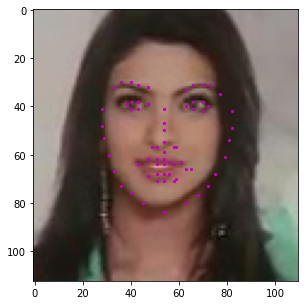

In [32]:
image_name, image, key_pts = select_image(150)
print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

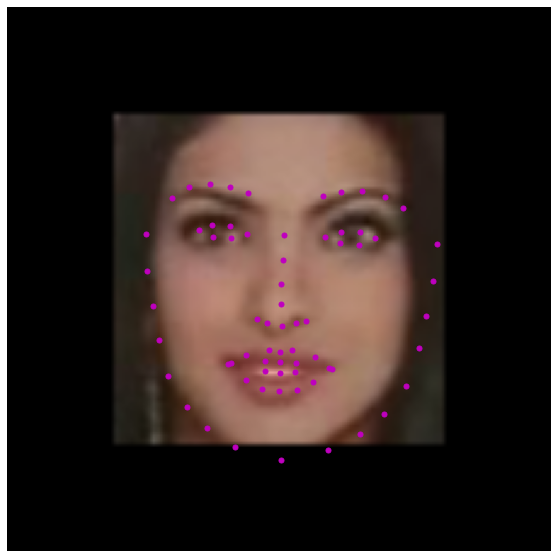

In [37]:
roi_copy, predicted_key_pts = predict_and_filter_face(image, net, face_cascade)

Rotation angle (in degrees): -1.9091524329963763


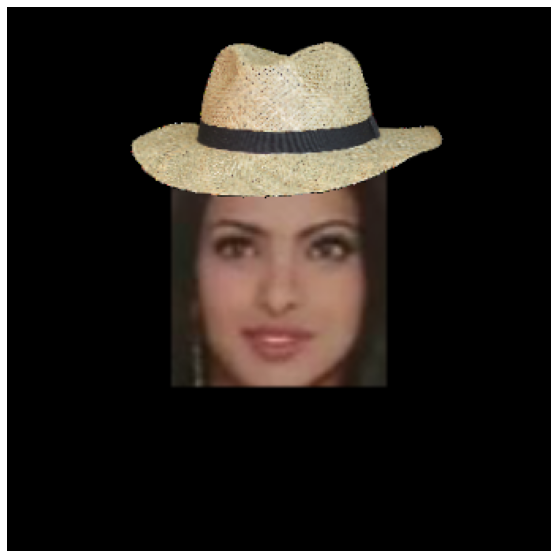

In [39]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'straw_hat', 60, 0)

Rotation angle (in degrees): -1.9091524329963763


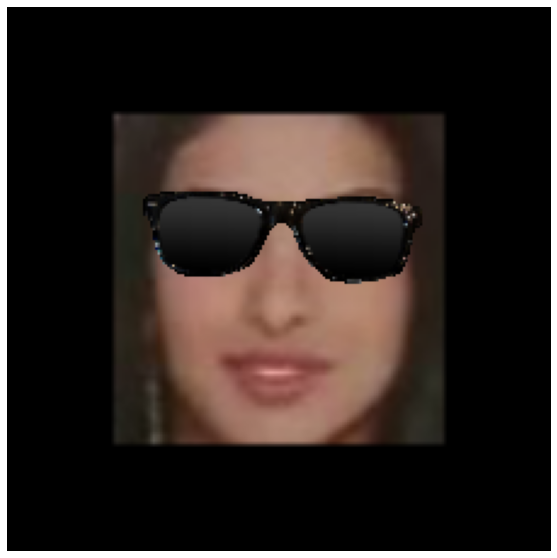

In [36]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'sunglasses', 0, 10)

Rotation angle (in degrees): -1.9091524329963763


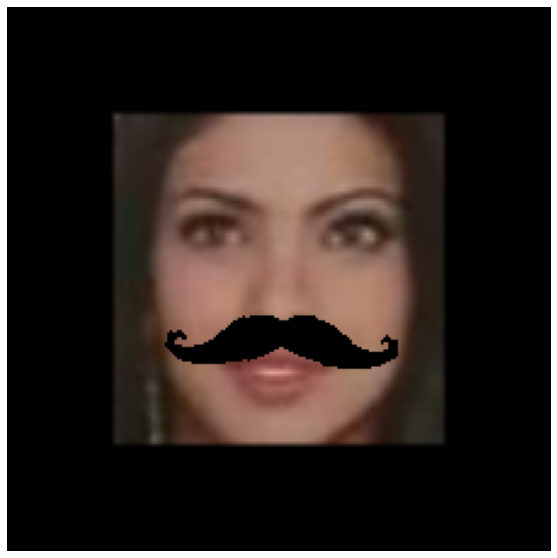

In [16]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'moustache', 0, 10)

Image name:  Leszek_Miller_01.jpg


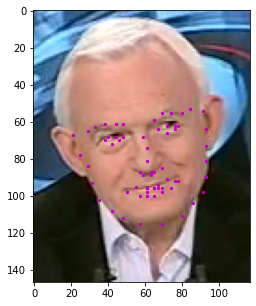

In [40]:
image_name, image, key_pts = select_image(100)
print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

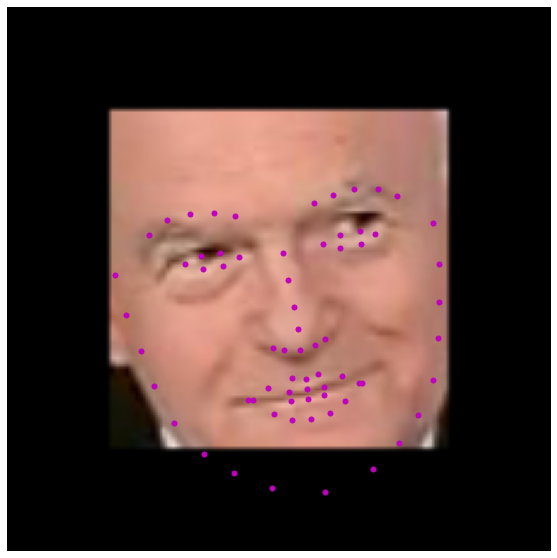

In [41]:
roi_copy, predicted_key_pts = predict_and_filter_face(image, net, face_cascade)

Rotation angle (in degrees): 9.176203340376144


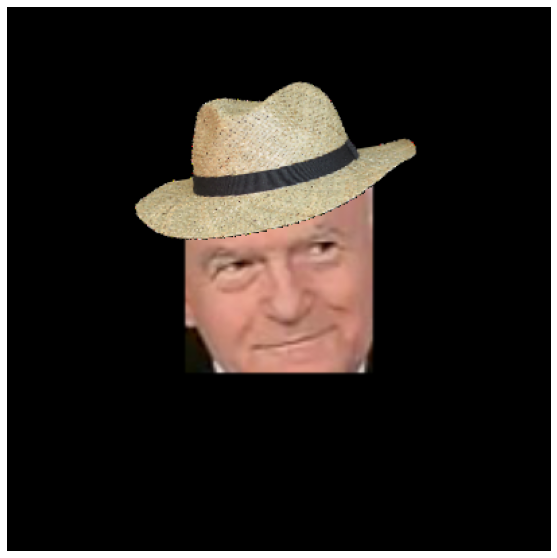

In [42]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'straw_hat', 90, 20)

Rotation angle (in degrees): 9.176203340376144


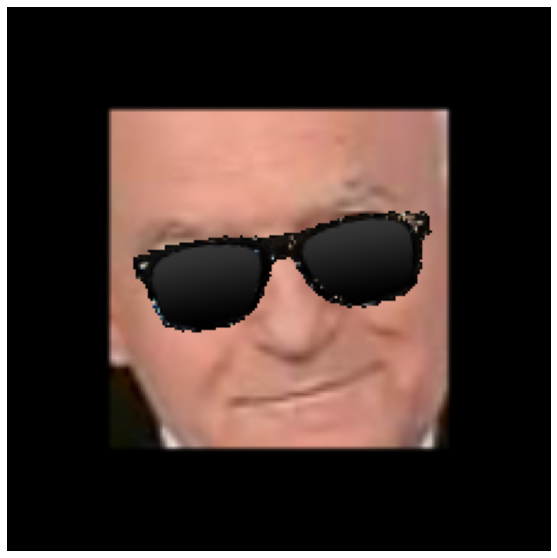

In [19]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'sunglasses', 0, 20)

Rotation angle (in degrees): 9.176203340376144


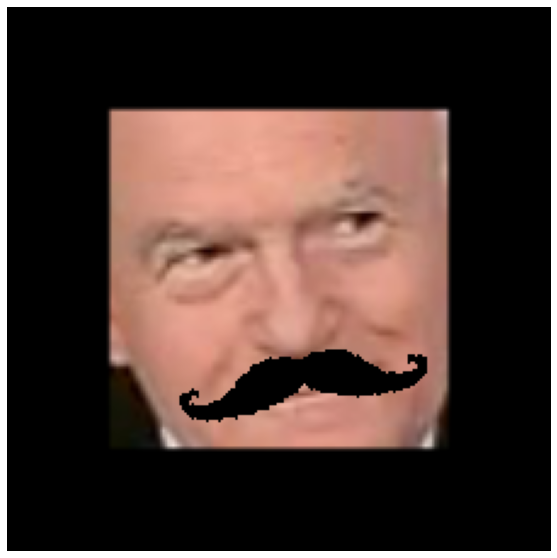

In [20]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'moustache', 0, 10)

Image name:  Luc_Montagnier_50.jpg


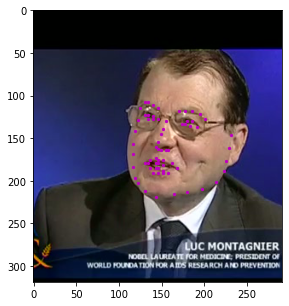

In [43]:
image_name, image, key_pts = select_image(130)
print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

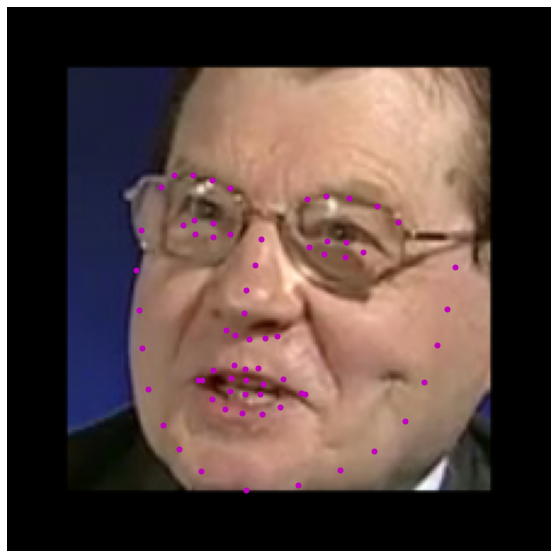

In [44]:
roi_copy, predicted_key_pts = predict_and_filter_face(image, net, face_cascade)

Rotation angle (in degrees): -6.632514615138462


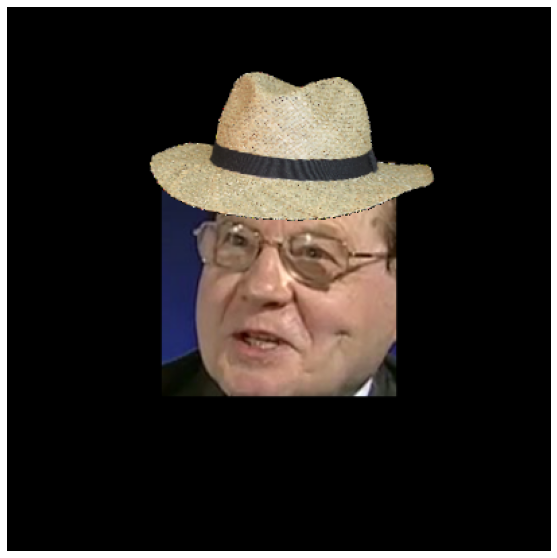

In [45]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'straw_hat', 90, 20)

Rotation angle (in degrees): -6.632514615138462


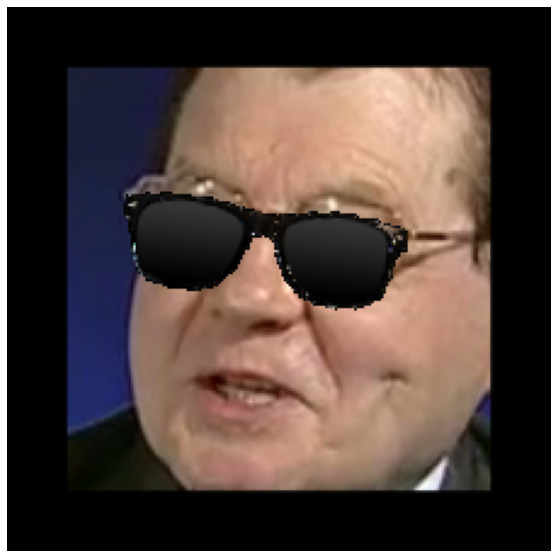

In [23]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'sunglasses', 0, 20)

Rotation angle (in degrees): -6.632514615138462


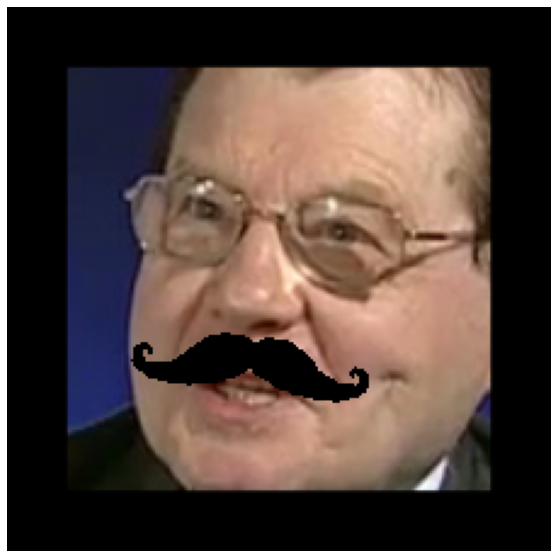

In [24]:
apply_face_filter(roi_copy, predicted_key_pts[0], config_dict, 'moustache', 0, 10)